# CUDA Training and Hooks from Foundations

#### Last Time

[Most recently](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/05b_early_stopping_my_reimplementation.ipynb?flush_cache=true), we saw how implementing callbacks that inherit from Python's `Exception` class can be a concise way to write the logic that can execute cancellation of the training of a batch, epoch, or entire cycle.

Early stopping was the latest in the ever-expanding set of applications of callbacks through which we've been journeying in our last couple of notebooks.

#### CUDA

Today, we'll implement a convolutional neural network for the first time and find out, first-hand, just why training on GPUs (as opposed to training the CPU, as we have been doing thus far) is a crucial step to enabling most meaningful applications of deep learning.

In PyTorch, creating a simple callback gives us a straightforward way of ensuring that a deep learning model, and its inputs and targets, are stored and trained on the same device. After first demonstrating just how long it takes to train our simple CNN on the CPU, we'll implement this callback and show how using the GPU speeds things up enough to make deep learning practical.

#### Hooks

Then we take a deep dive and explore how PyTorch has implemented hooks, which are a form of callback that allows practitioners to observe the values of each layer's outputs at different phases of training.

The first step is to create our own, manual, implementation of hooks from scratch. Then, we move on to explore how to register PyTorch hooks at network layers, as well as how to extract, summarize, and plot graphs of the activation values stored in these hooks. Finally, we touch on the importance of always removing PyTorch hooks from their layers, once these hooks are no longer needed. We'll see that using hooks with a context manager is a powerful way to ensure we don't forget this crucial step.

Then through the course of a few small experiments, we give a taste of how helpful hooks are for on-the-fly debugging and prototyping.

#### Generalized ReLU

Finally, we implement a variation of the ReLU activation function that gives practitioners some extra settings to tweak!

In [179]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
#export
from exports.nb_05b import *
torch.set_num_threads(2)

### Simple 4-layer CNN

As with all our previous notebooks, we're still working on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/index.html). Now, however, instead of creating a DNN and flattening the MNIST inputs into long single dimension lists, we'll input them into our CNN in their original, 2-dimensional shape.

In [181]:
x_train, y_train, x_valid, y_valid = get_data()

We've already created a function to normalize any dataset. As a convenience for our application, we now wrap it with the logic to return both a normalized training set, as well as a validation set that's been normalized by the mean/std of the training set:

In [182]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [183]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [184]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [185]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

We'll find over and over that it's really convenient to create a `Lambda` class that inherists from nn.Module. This class can convert a simple function into a layer which can then be inserted inside an `nn.Sequential` call. 

For our circumstances here, this allows us to insert a layer that resizes our inputs into a shape appropriate to be fed into a CNN. 

In [186]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)

In [187]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

`mnist_resize()` takes a flat input vector of size `bs` x `784` and converts each list of pixels to a `28` x `28` 2-d array. Each batch's inputs will have the shape `(bs, 1, 28, 28)`.

Note that the reason we took the trouble to define and name our `mnist_resize` function (rather than just leave it defined as a lambda which could also conceivably be fed to the `Lambda` layer class), was because if we don't do this our model won't pickle properly, and in turn  won't be able to be saved by PyTorch. Therefore we always need to explicitly name any function that'll form the core of any `Lambda` layer class.

We also create a `flatten()` function to be used at the other end of our CNN, in order to flatten the final convolutional layer's output so that it can be fed into fully-connected layer(s) at the network's head.

In [188]:
def flatten(x): return x.view(x.shape[0], -1)

Here's the structure of the CNN when we put everything together:

In [189]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2, stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [190]:
model = get_cnn_model(data)
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [191]:
%time run.fit(1, learn)

train: [1.9510646875, tensor(0.3501)]
valid: [1.07879375, tensor(0.6239)]
CPU times: user 15.1 s, sys: 12.1 s, total: 27.3 s
Wall time: 6.83 s


It took nearly 10 seconds to train our CNN for one epoch. It's not difficult to imagine that if we wanted to train deeper/wider models for longer durations, it would be impractical to proceed with doing so on the CPU.

### CUDA

Thankfully, we have Nvidia GPUs and the accompanying CUDA package, which is the parallel programming library Nvidia created to enable numerical computing using its GPUs. This allows us to perform parallelized training of our models, which significantly speeds up training.

Let's create a simple callback that'll ensure our model's training is always done on the GPU whenever this callback is included in our list of callback functions. We demonstrate two potential implementations: the first one is more flexible, but comes at the cost of extra verbosity. The second is more concise and convenient, but loses a little bit of flexibility.

First off, we need to let PyTorch know which GPU to use:

In [192]:
device = torch.device('cuda',0)
device

device(type='cuda', index=0)

Alternately, we could just run:

In [193]:
torch.cuda.set_device(0)

In [194]:
# More flexible. Useful if we want to train one model on one GPU and 
# another model on a second GPU, at the same time.
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model.to(device)
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.to(device), self.yb.to(device)

In [195]:
#export

# Less flexible but convenient
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

Now let's train our model once more, this time on the GPU!

In [196]:
cbfs.append(CudaCallback)
model = get_cnn_model(data)
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [197]:
%time run.fit(3, learn)

train: [2.16362640625, tensor(0.2037, device='cuda:0')]
valid: [1.04162880859375, tensor(0.6899, device='cuda:0')]
train: [0.5645583203125, tensor(0.8226, device='cuda:0')]
valid: [0.614362841796875, tensor(0.8281, device='cuda:0')]
train: [0.18869443359375, tensor(0.9432, device='cuda:0')]
valid: [0.1993324462890625, tensor(0.9408, device='cuda:0')]
CPU times: user 3.68 s, sys: 639 ms, total: 4.32 s
Wall time: 4.29 s


We were able to train our model for 3 epochs on the GPU in just under two-thirds of the time it took to train for a single epoch on the CPU!

### Refactoring our CNN

We're just about ready to dive into PyTorch hooks. First, though, let's refactor our CNN to make it more flexible and concise.

The first thing we can do is combine our convolutional layers and corresponding ReLU activation functions into one function:

In [198]:
def conv2d(n_in, n_out, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride),
        nn.ReLU()
    )

Previously we had created a `Lambda` layer that called our `mnist_resize()` function to transform the MNIST inputs into the the proper shape for our CNN. 

We could actually accomplish the same thing by using a callback, instead. Moving the customized MNIST resize layer out of the model has the benefit of making our model more flexible. Thanks to its use of adaptive average pooling, our model proper will now be compatible with any size of input. 

In [199]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

# Helper function to reshape a batch of input images so that 
# they're organized as PyTorch expects: (batch size, channels, height, width)
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,) + size))
    return _inner

The logic specific to resizing the MNIST inputs is now defined outside of model layers:

In [200]:
mnist_view = view_tfm(1, 28, 28)

And we use `partial()` to pass the transform defined under `mnist_view` to the batch transform callback:

In [201]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

Output size of each layer in our CNN:

In [202]:
n_outs = [8, 16, 32, 32]

In [203]:
def get_cnn_layers(data, n_outs):
    n_outs = [1] + n_outs
    return [
        conv2d(n_outs[i], n_outs[i+1], 5 if i==0 else 3) for i in range(len(n_outs) - 1)
    ] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(n_outs[-1], data.c)
    ]

def get_cnn_model(data, n_outs):
    return nn.Sequential(*get_cnn_layers(data, n_outs))

While we're at it, here's a helper function to help set up a training cycle:

In [204]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [205]:
model = get_cnn_model(data, n_outs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [206]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

Great! Our model's structure looks exactly as it should.

In [207]:
run.fit(3, learn)

train: [2.25234859375, tensor(0.1909, device='cuda:0')]
valid: [2.6354185546875, tensor(0.2124, device='cuda:0')]
train: [1.04397828125, tensor(0.6580, device='cuda:0')]
valid: [0.341184521484375, tensor(0.8942, device='cuda:0')]
train: [0.2800410546875, tensor(0.9127, device='cuda:0')]
valid: [0.18725084228515626, tensor(0.9407, device='cuda:0')]


### Hooks

As we touched upon earlier in this notebook's intro, hooks are the way we peer into our network's layers in order to understand how they behave during training. We can actually grab the actual activation outputs themselves and compute summarizing metrics if we desire, such as mean or standard deviation. 

Moreover, we can grab these layer activation values at any given forward or backward pass during training. This is useful to observe things like gradient propagation, and whether or not activations explode at later layers or gradients disappear at earlier layers.

#### Manual Insertion

We'll cover various approaches we could use to implement hooks, beginning with a manual, from-scratch implementation to retrieve the mean and standard deviations of layers during the forward pass. This doesn't require registration of PyTorch hooks.

In [210]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds =  [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.data.mean())
                self.act_stds [i].append(x.data.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [211]:
model = SequentialModel(*get_cnn_layers(data, n_outs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)
run.fit(2, learn)

train: [2.1989046875, tensor(0.2053, device='cuda:0')]
valid: [2.3529142578125, tensor(0.1104, device='cuda:0')]
train: [0.8938284375, tensor(0.7015, device='cuda:0')]
valid: [0.37950791015625, tensor(0.8875, device='cuda:0')]


Now let's take a look at the mean and standard deviations of each layer's activation. We'll first observe how they change during the first 200 iterations of training, and then zoom into what took place during the first 10 iterations:

In [212]:
def plot_layer_stat(layer_outputs, metric, title, num_layers, cutoff=None):
    for l in layer_outputs: 
        plt.plot(l) if cutoff==None else plt.plot(l[:cutoff])
    plt.xlabel('Iterations')
    plt.ylabel(f'Activation Output {metric}')
    plt.title(title)
    plt.legend([f'Layer {i}' for i in range(num_layers)]);

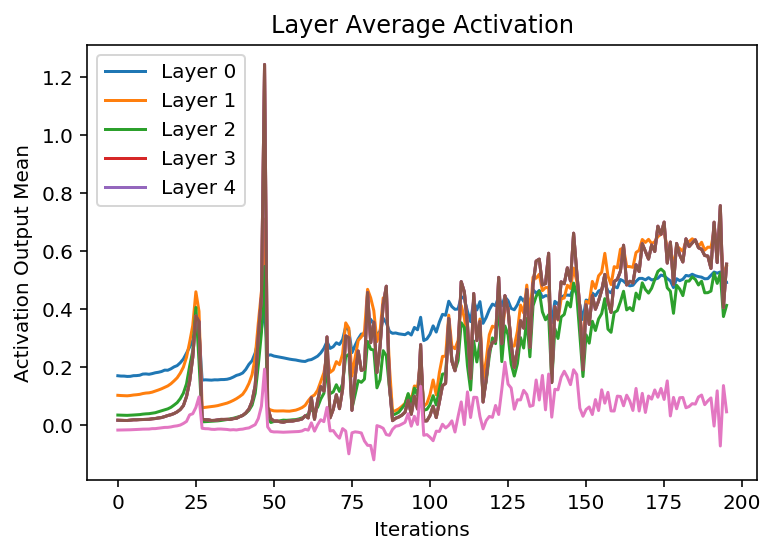

In [213]:
plot_layer_stat(model.act_means, 'Mean', 'Layer Average Activation', 5)

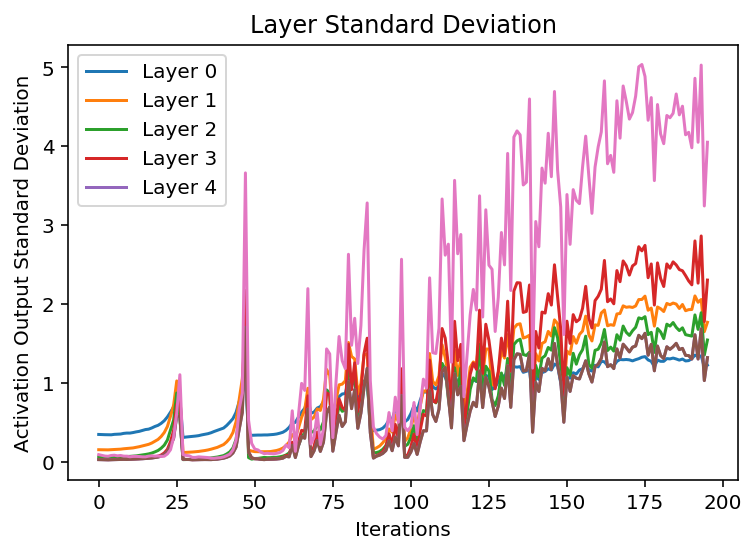

In [214]:
plot_layer_stat(model.act_stds, 'Standard Deviation', 'Layer Standard Deviation', 5)

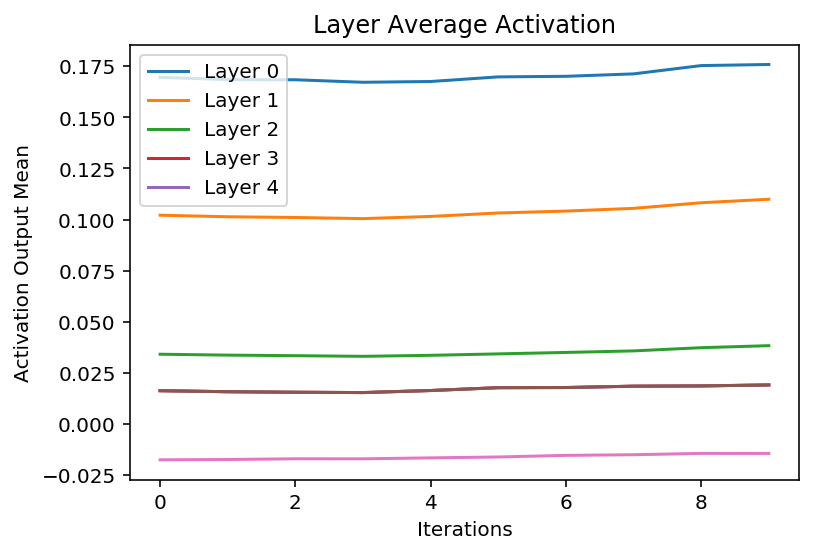

In [215]:
plot_layer_stat(model.act_means, 'Mean', 'Layer Average Activation', 5, cutoff=10)

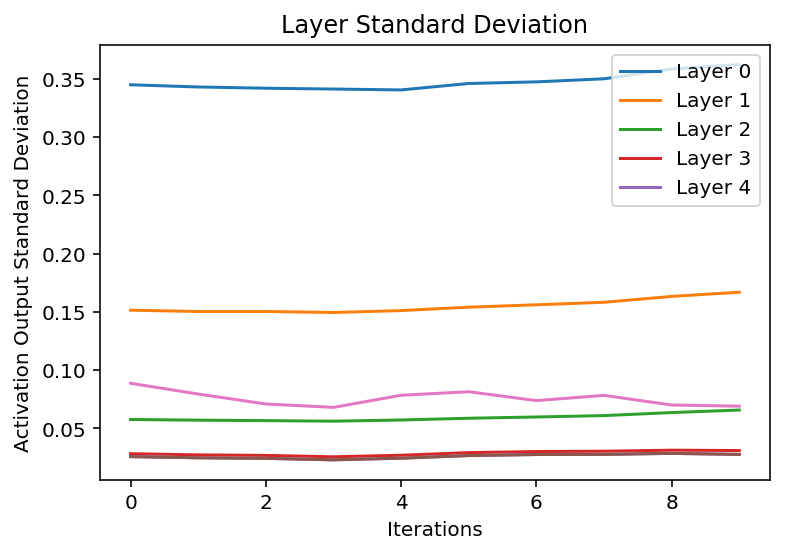

In [216]:
plot_layer_stat(model.act_stds, 'Standard Deviation', 'Layer Standard Deviation', 5, cutoff=10)

At the very beginning of training, the lower the layer, the higher the mean and standard deviation of its activations. As training proceeds, the activation outputs of the layers move consistently with each other, with the exception of those of the final layer (Layer 4), whose activation output values are noticeably more volatile, and on average, don't ever escape from near zero.

Note that this problem of final layer activations dying out was what motivated [Glorot and Bengio's paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) that proposed Xavier initialization.

#### PyTorch Hooks

Instead of having to always manually grab activations, PyTorch offers us a quick way to do this by registering hooks with network layers. PyTorch hooks can be added to any nn.Module. When created, a hook must be registered to a specific layer. Then during training, the hook will be executed during the forward pass (using forward hooks) or during the backward pass (backward hooks).

The moral of the story is: with PyTorch hooks, we don't have rewrite our models should we decide after the fact that we want to explore their layers' behavior.

In [38]:
model = get_cnn_model(data, n_outs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [39]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is always attached to a layer and must contain a function that at as a minimum has these three arguments:
* module
* input
* output

Below is an example of a function that does what our manual approach did above, only this time it works with a registered PyTorch hook:

In [40]:
def append_stats(i, mod, inp, outp):
    if mod.training:
        act_means[i].append(outp.data.mean())
        act_stds [i].append(outp.data.std())

To register a forward hook at a given layer, l, we call `l.register_forward_hook()`:

In [41]:
for i, l in enumerate(model): l.register_forward_hook(partial(append_stats, i))

In [42]:
run.fit(1, learn)

train: [2.0555934375, tensor(0.2758, device='cuda:0')]
valid: [1.05198095703125, tensor(0.6838, device='cuda:0')]


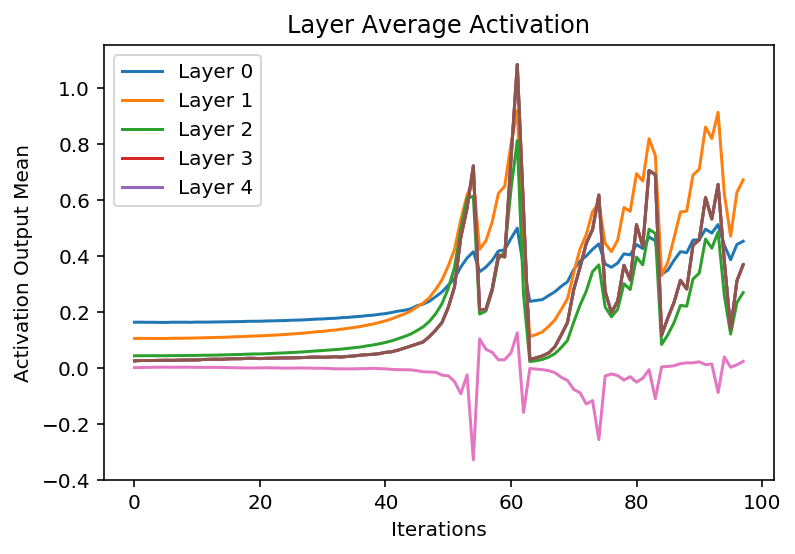

In [43]:
plot_layer_stat(act_means, 'Mean', 'Layer Average Activation', 5)

#### Refactoring into a Hook class

Registering hooks isn't a one-way street: it's crucial that hooks are explictly removed once they are deleted. If these references aren't removed, GPU memory won't be released when our model is deleted, and this will make it more cumbersome to run successive experiments.

Putting the methods to both register and remove hooks into the same `ForwardHook` class will make it easier for us to make sure we don't overlook this important step.

In [44]:
#export
def children(l): return list(l.children())

class ForwardHook():
    def __init__(self, l, f): self.hook = l.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())

In [45]:
model = get_cnn_model(data, n_outs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)
hooks = [ForwardHook(l, append_stats) for l in children(model[:5])]

In [46]:
run.fit(1, learn)

train: [1.73666859375, tensor(0.4218, device='cuda:0')]
valid: [0.6709568359375, tensor(0.7738, device='cuda:0')]


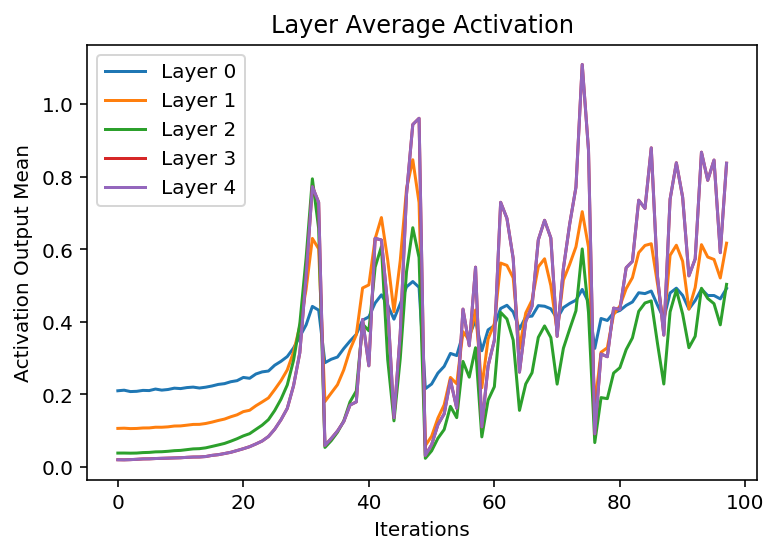

In [47]:
plot_layer_stat([h.stats[0] for h in hooks], 'Mean', 'Layer Average Activation', 5)

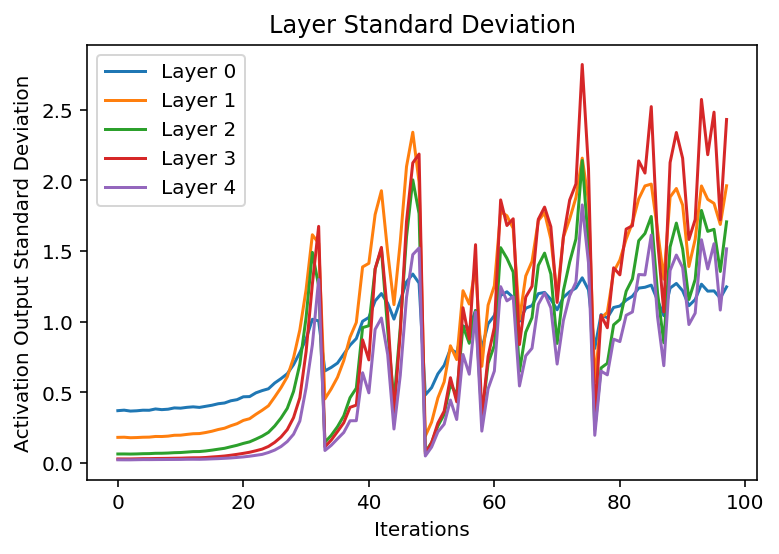

In [48]:
plot_layer_stat([h.stats[1] for h in hooks], 'Standard Deviation', 'Layer Standard Deviation', 5)

In [49]:
for h in hooks: h.remove()

#### Creating a Hooks class

Oftentimes we will want to register more than one hook for our models. It will be helpful to create a class that can allow us to effectively access and manage each of these hooks. We would need this class to allow us to access our hooks via the following:
1. A single index
* A slice (like `1:5`)
* A list of indices
* a mask of indices(i.e. `[True, False, False, True, ... ]`)

What we can do is first create a general class that we'll call `ListContainer`, which will allow us to index into an array using any of the four methods listed above. We'll then create the `ForwardHooks` class, which while inheriting from `ListContainer`, will also contain hook-specific logic such as registering and removing hooks.

In [50]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        # 1., 2. Indexing via a single index or a slice
        try: return self.items[idx]
        except TypeError:
            # 4. If indexing via a mask
            if isinstance(idx[0], bool):
                assert len(idx)==len(self)
                return [o for m,o in zip(idx,self.items) if m]
            # 3. If indexing via a list of indices
            return [self.items[i] for i in idx]
    
    # Do other useful list operations.
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items) # to do things like 'for x in ...'
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10: res = res[:-1] + '...]'
        return res

In [51]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

So far, so good. Let's make sure we can index into a `ListContainer()` object in the way we'd want to:

In [52]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [53]:
t[tensor(3)]

3

In [54]:
#export
from torch.nn import init

class ForwardHooks(ListContainer):
    def __init__(self, ms, f): super().__init__([ForwardHook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [55]:
model = get_cnn_model(data, n_outs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)
hooks = ForwardHooks(model, append_stats)
hooks

ForwardHooks (7 items)
[<__main__.ForwardHook object at 0x7f36fbb19828>, <__main__.ForwardHook object at 0x7f36fbb19320>, <__main__.ForwardHook object at 0x7f36fbb19780>, <__main__.ForwardHook object at 0x7f36fbb198d0>, <__main__.ForwardHook object at 0x7f36fbb19278>, <__main__.ForwardHook object at 0x7f36fbb196a0>, <__main__.ForwardHook object at 0x7f36fbb19b38>]

How cool is that! We were able to register forward hooks at each layer in our network, in just one line of code! Let's doublecheck that we can indeed access these hooks. 

We'll run a batch of training data through the first layer of our network and then view its mean/standard deviation by accessing the first item in the model's hooks list.

In [56]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

We can verify that the inputs were properly normalized

In [57]:
x.mean(), x.std()

(tensor(-0.0012, device='cuda:0'), tensor(0.9990, device='cuda:0'))

Now let's run these inputs through our model's first layer:

In [58]:
p = model[0](x)

Here's the mean and standard deviation of this layer's activation outputs:

In [59]:
hooks[0].stats

([tensor(0.1868, device='cuda:0')], [tensor(0.3123, device='cuda:0')])

Let's make sure our hook is storing the right values:

In [60]:
p.mean(), p.std()

(tensor(0.1868, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.3123, device='cuda:0', grad_fn=<StdBackward0>))

Looks great! To illustrate how useful hooks are for quick debugging and prototyping, we'll change the layer weight init to Kaiming normal and see what effect, if any, this change has on the first layer's activation outputs:

In [61]:
model = get_cnn_model(data, n_outs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)
hooks = ForwardHooks(model, append_stats)

for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()
        
model[0](x)
hooks[0].stats

([tensor(0.5007, device='cuda:0')], [tensor(1.0997, device='cuda:0')])

We can immediately see Kaiming normal init has a pretty big effect on our model's first layer outputs: their mean and standard deviation are now much closer to 0.5 and 1.0, respectively.

Our hooks class allows us to properly de-register all the forward hooks in one fell swoop:

In [62]:
hooks.remove()

You may be wondering what the `__enter__` and `__exit__` dunder methods in the `ForwardHooks` class were intended to accomplish. Adding these two methods to a Python class will allow us to use an object from that class as a **context manager**. 

Since we placed `self.remove()` inside the class' `__exit__` method, using a context manager ensures that all the hooks are automatically removed once we are out of the `with` block:

In [63]:
def get_labels(ax, metric, title):
    return ax.set_xlabel('Iterations'), ax.set_ylabel(f'Activation Output {metric}'), ax.set_title(title)

train: [2.31423328125, tensor(0.1755, device='cuda:0')]
valid: [2.1956341796875, tensor(0.2323, device='cuda:0')]
train: [1.5558578125, tensor(0.4648, device='cuda:0')]
valid: [0.55494384765625, tensor(0.8204, device='cuda:0')]


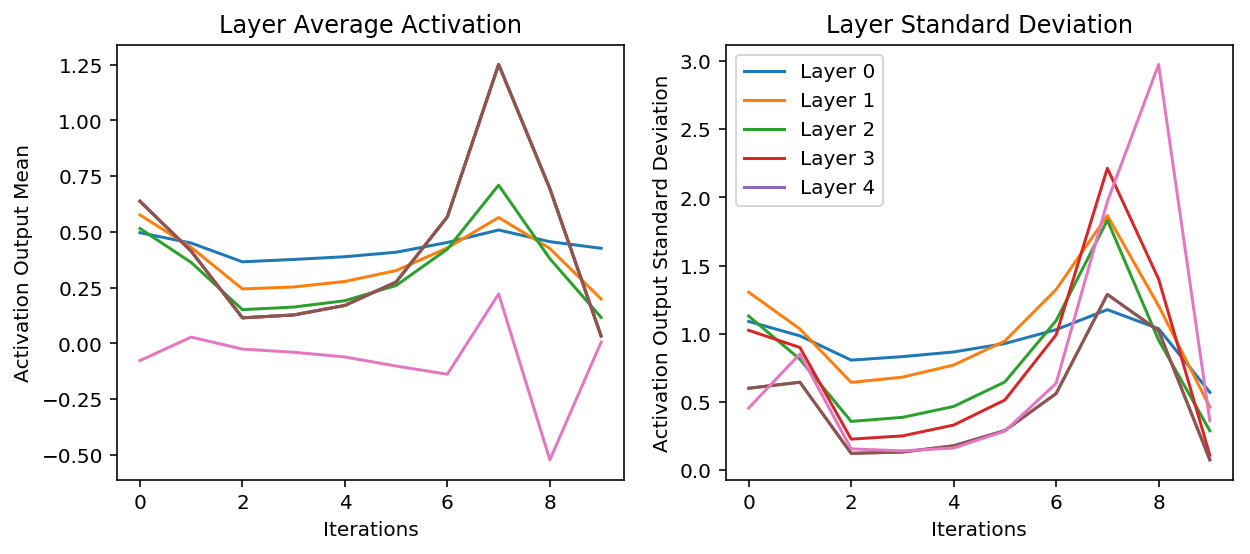

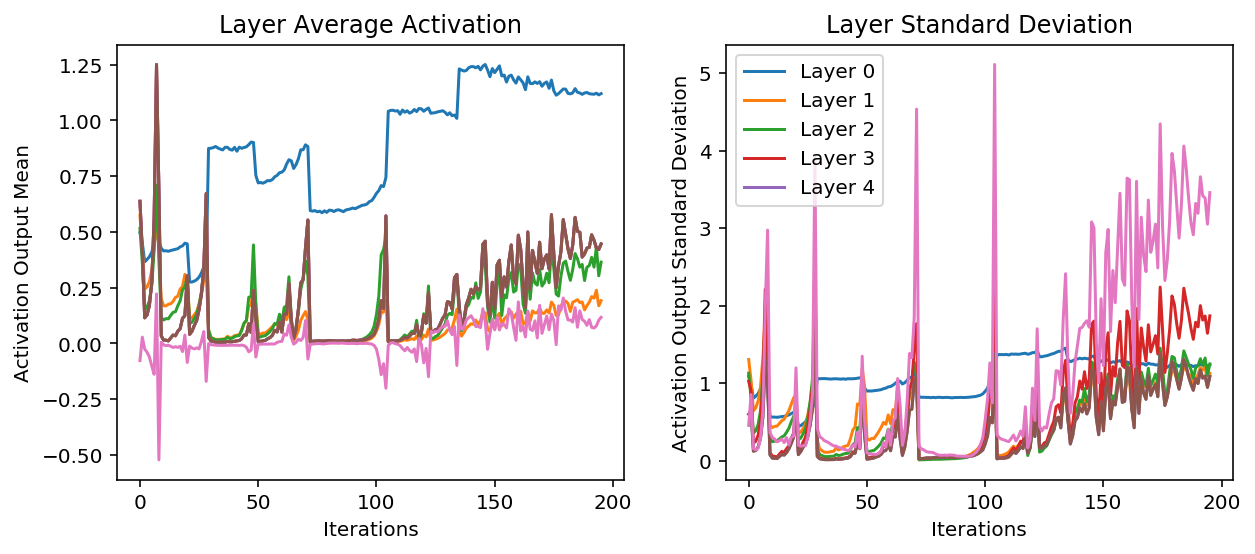

In [64]:
with ForwardHooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Layer {i}' for i in range(5)])
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Layer {i}' for i in range(5)]);

### Generalized ReLU

We conclude this notebook by designing a `GeneralReLU` class that implements a ReLU function that can be shifted up or down the y-axis as desired by the user. This class will also allow there to be designated a maximum value at which to cap outputs.

In [65]:
#export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, max_val=None):
        super().__init__()
        self.leak, self.sub, self.max_val = leak, sub, max_val
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.max_val is not None: x.clamp_max_(self.max_val)
        return x

We reimplement the convenience functions we use for setting up a CNN model, so that they can make use of our new `GeneralRelu` class:

In [66]:
#export
def conv_layer(n_in, n_out, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(n_in, n_out, ks, padding=ks//2, stride=stride),
        GeneralRelu(**kwargs)
    )

def get_cnn_layers(data, n_outs, layer, **kwargs):
    n_outs = [1] + n_outs
    return [layer(n_outs[i], n_outs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(n_outs) - 1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(n_outs[-1], data.c)]

def get_cnn_model(data, n_outs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, n_outs, layer, **kwargs))

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a = 0.1)
            l[0].bias.data.zero_()

Let's try out our `GeneralRelu` activation function and see how it performs. We'll cap its maximum output at `6.0`, make it a little leaky (`0.1`), and shift all outputs by `0.4`. 

First off, here's a plot that demonstrates the modifications we're applying to the ReLU activation function:

In [135]:
ins = torch.arange(-10,11,0.01)
relu_func = GeneralRelu(leak=0.1, sub=0.4, max_val=6.0)
outs = [relu_func.forward(i.float()) for i in ins]

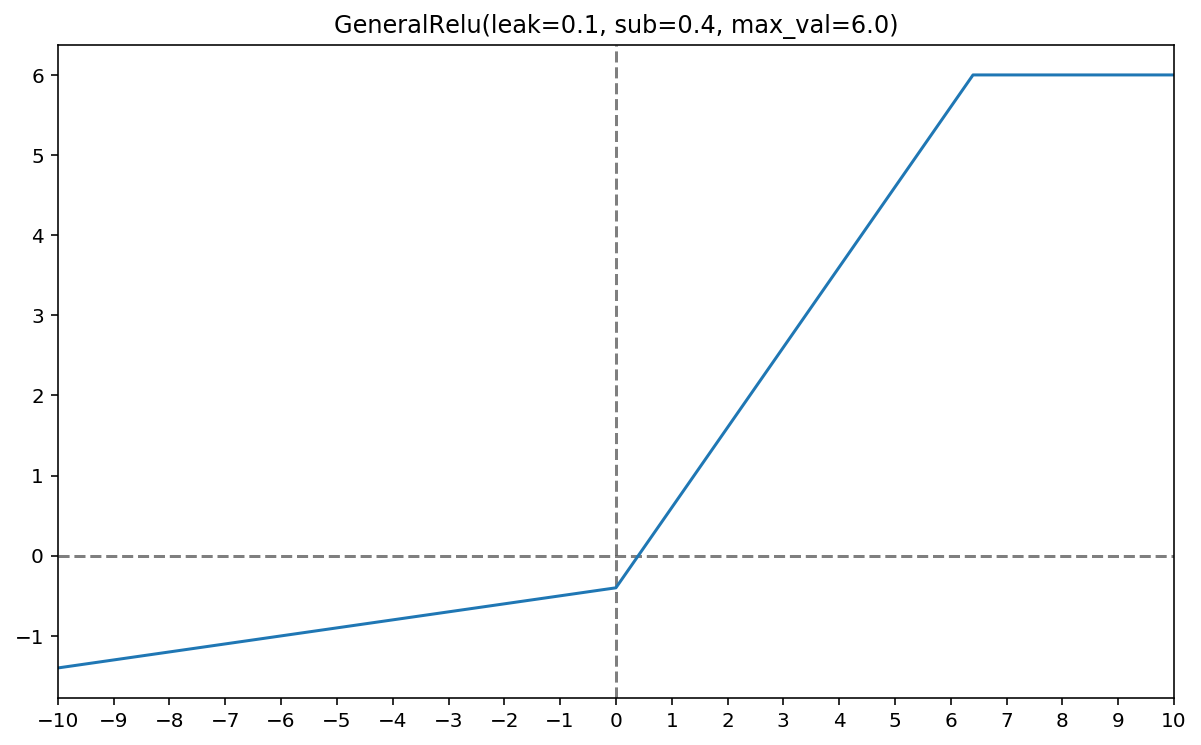

In [136]:
plt.figure(figsize=(10,6))
plt.xlim(left=-10,right=10)
plt.xticks(range(-10,11))
plt.axvline(x=0, color='k', alpha=0.5).set_linestyle('--')
plt.axhline(y=0, color='k', alpha=0.5).set_linestyle('--')
plt.title('GeneralRelu(leak=0.1, sub=0.4, max_val=6.0)')
plt.plot(ins.cpu().numpy(), outs);

Now let's train the model:

train: [0.492210625, tensor(0.8446, device='cuda:0')]
valid: [0.1512771484375, tensor(0.9568, device='cuda:0')]
train: [0.131150791015625, tensor(0.9603, device='cuda:0')]
valid: [0.1015089111328125, tensor(0.9690, device='cuda:0')]


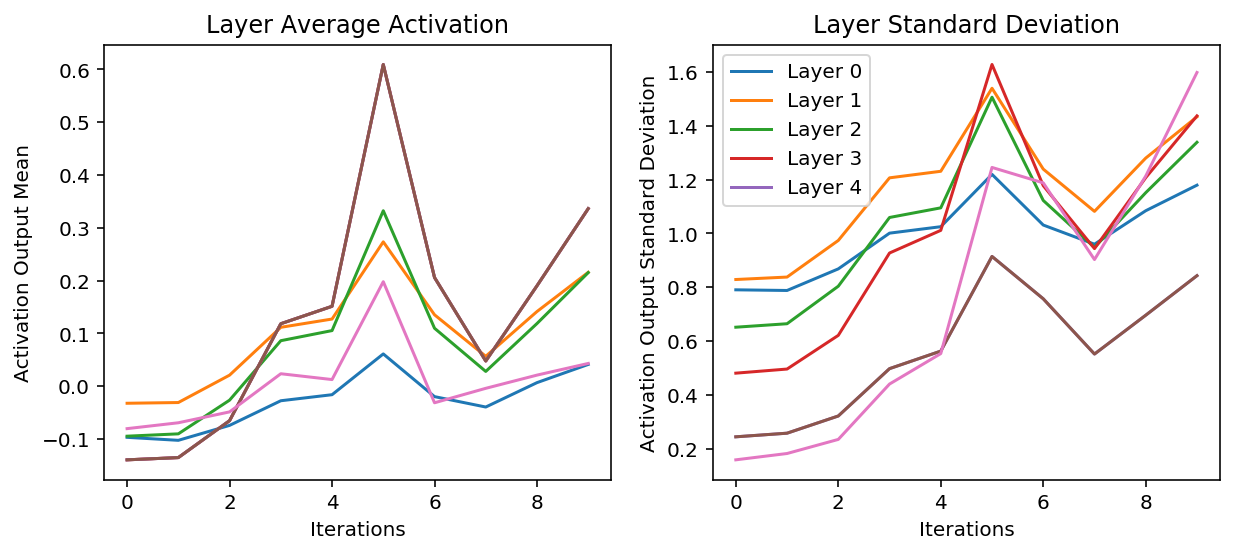

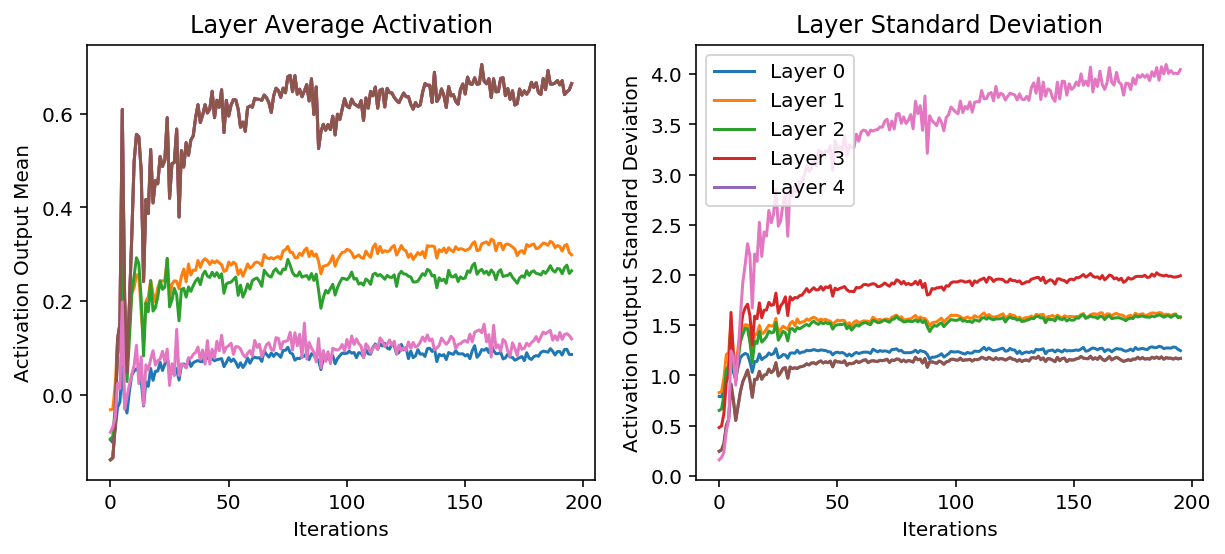

In [138]:
model = get_cnn_model(data, n_outs, conv_layer, leak=0.1, sub=0.4, max_val=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

with ForwardHooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Layer {i}' for i in range(5)])
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
        get_labels(ax0, 'Mean', 'Layer Average Activation')
        get_labels(ax1, 'Standard Deviation', 'Layer Standard Deviation')
    plt.legend([f'Layer {i}' for i in range(5)]);

Using our modified ReLU activation function helped our model train to nearly a 20% higher validation accuracy. This shouldn't be surprising as the we can see in our graphs that the activation outputs of the layers converge very rapidly. What's more, the final layer's outputs move up and away from zero very early and remain there.

A `96%` validation accuracy is pretty impressive, but let's see if we can improve on this still more by using a cosine learning rate scheduler. 

We'll create one final wrapper which includes parameters for adjusting most of the things we've implemented up to this point:

In [171]:
#export
def get_learn_run(n_outs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, n_outs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In order to do an apples-to-apples comparison on the effectiveness of including the cosine learning rate scheduler, we'll first train a model from scratch for `8` epochs with a constant learning rate of `1.0`.

In [172]:
learn, run = get_learn_run(n_outs, data, 1., conv_layer, cbs=cbfs)

In [173]:
run.fit(8, learn)

train: [2.004555625, tensor(0.3154, device='cuda:0')]
valid: [1.204858203125, tensor(0.6157, device='cuda:0')]
train: [0.9988096875, tensor(0.6890, device='cuda:0')]
valid: [0.3475510009765625, tensor(0.8944, device='cuda:0')]
train: [0.215442265625, tensor(0.9360, device='cuda:0')]
valid: [0.1391203369140625, tensor(0.9599, device='cuda:0')]
train: [0.1524330078125, tensor(0.9531, device='cuda:0')]
valid: [0.12776053466796874, tensor(0.9627, device='cuda:0')]
train: [0.10533904296875, tensor(0.9683, device='cuda:0')]
valid: [0.11810628662109375, tensor(0.9686, device='cuda:0')]
train: [0.1442015625, tensor(0.9578, device='cuda:0')]
valid: [0.1260052001953125, tensor(0.9653, device='cuda:0')]
train: [0.088338876953125, tensor(0.9731, device='cuda:0')]
valid: [0.1040033203125, tensor(0.9722, device='cuda:0')]
train: [0.07059671875, tensor(0.9784, device='cuda:0')]
valid: [0.0955426025390625, tensor(0.9732, device='cuda:0')]


Now we train from scratch another model, this time using our cosine learning rate scheduler:

In [174]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [175]:
learn, run = get_learn_run(n_outs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [176]:
run.fit(8, learn)

train: [1.13552828125, tensor(0.6310, device='cuda:0')]
valid: [0.51487314453125, tensor(0.8386, device='cuda:0')]
train: [0.318440625, tensor(0.9042, device='cuda:0')]
valid: [0.3007919921875, tensor(0.9077, device='cuda:0')]
train: [0.27427619140625, tensor(0.9177, device='cuda:0')]
valid: [0.16531270751953125, tensor(0.9520, device='cuda:0')]
train: [0.117500244140625, tensor(0.9632, device='cuda:0')]
valid: [0.095922802734375, tensor(0.9724, device='cuda:0')]
train: [0.0742403662109375, tensor(0.9772, device='cuda:0')]
valid: [0.0907139404296875, tensor(0.9708, device='cuda:0')]
train: [0.05322654296875, tensor(0.9836, device='cuda:0')]
valid: [0.0611769775390625, tensor(0.9819, device='cuda:0')]
train: [0.0395937890625, tensor(0.9878, device='cuda:0')]
valid: [0.058957958984375, tensor(0.9839, device='cuda:0')]
train: [0.03176380859375, tensor(0.9902, device='cuda:0')]
valid: [0.05942740478515625, tensor(0.9840, device='cuda:0')]


After `8` epochs of training under a cosine learning rate regime, our model achieves a validation accuracy of `98.4%` -- over one percentage point higher than was reached by the model that held a constant learning rate over the same number of epochs.

### Export

[Stas Bekman](https://forums.fast.ai/u/stas/summary) wrote the following, which going forward will allow us to export any notebook using a single method call:

In [217]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script_my_reimplementation.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [218]:
nb_auto_export()

<IPython.core.display.Javascript object>